In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import os

In [3]:
# Downscale thumbnails to 360p for training
img_size = (480, 360)

def loadImage(path):
	img = Image.open(path, 'r').convert('RGB').resize(img_size)
	# Convert colors from 0-255 to 0-1
	return np.asarray(img) / 255

In [4]:
# AI tries to match target values given source values
source = []
target = []

# Import thumbnails from dataset/ folder
for img in os.listdir('dataset'):
	source.append(loadImage(f'dataset/{img}'))
	views, subs = img[12:-4].split("_")
	target.append(int(views) / int(subs))

# Convert to numpy arrays
source = np.array(source)
target = np.array(target)

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(source, target, test_size=0.1)

In [6]:
model = keras.models.Sequential(
	[
		# Input has 3 dimensions: height x width x 3 color channels (RGB)
		keras.Input(shape=(img_size[1], img_size[0], 3)),

		# Try to learn small-scale details + shrink input
		keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='Same', activation='relu'),
		keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='Same', activation='relu'),
		keras.layers.MaxPooling2D(pool_size=2, strides=2),

		# Try to learn medium-scale details + shrink input
		keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='Same', activation='relu'),
		keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='Same', activation='relu'),
		keras.layers.MaxPooling2D(pool_size=2, strides=2),

		# Try to learn large-scale details + shrink input
		keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='Same', activation='relu'),
		keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='Same', activation='relu'),
		keras.layers.MaxPooling2D(pool_size=2, strides=2),

		# Convert from 3D to 1D
		keras.layers.Flatten(),

		# Hope neuron layers do something useful, may blow up your GPU
		keras.layers.Dense(16384, activation='relu'), # idk whether to activate this
		keras.layers.Dense(4096), # idk whether to activate this

		# Output has 1 dimension: view count / subscriber count
		keras.layers.Dense(1)
	]
)

# 'mae' seems slightly better than 'mse'
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mae')
model.summary()

In [8]:
batch_size = 128
epochs = 64

history = model.fit(x_train, y_train,
	batch_size=batch_size,
	epochs=epochs,
	validation_data=(x_valid, y_valid),
	steps_per_epoch=x_train.shape[0] // batch_size # num_samples / batch_size
)

Epoch 1/64
7/7 [==============================] - 13s 162ms/step - loss: 2.0382 - val_loss: 1.2854
Epoch 2/64
7/7 [==============================] - 1s 106ms/step - loss: 2.0088 - val_loss: 1.2608
Epoch 3/64
7/7 [==============================] - 1s 111ms/step - loss: 1.8971 - val_loss: 1.2571
Epoch 4/64
7/7 [==============================] - 1s 114ms/step - loss: 2.0973 - val_loss: 1.2588
Epoch 5/64
7/7 [==============================] - 1s 109ms/step - loss: 2.0802 - val_loss: 1.2528
Epoch 6/64
7/7 [==============================] - 1s 107ms/step - loss: 0.4971 - val_loss: 1.2495
Epoch 7/64
7/7 [==============================] - 1s 111ms/step - loss: 1.9073 - val_loss: 1.2476
Epoch 8/64
7/7 [==============================] - 1s 119ms/step - loss: 1.9900 - val_loss: 1.2432
Epoch 9/64
7/7 [==============================] - 1s 119ms/step - loss: 1.9485 - val_loss: 1.2342
Epoch 10/64
7/7 [==============================] - 1s 106ms/step - loss: 1.8634 - val_loss: 1.2281
Epoch 11/64
7/7 [=

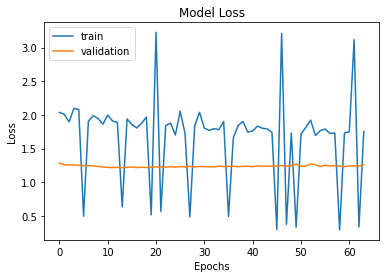

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "validation"])
plt.show()

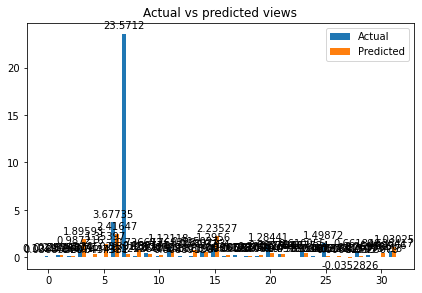

In [11]:
preds = model.predict(x_valid).flatten()

num_results = 32
width = 0.35
fig, ax = plt.subplots()
x = np.arange(num_results)
rects1 = ax.bar(x - width / 2, y_valid[:num_results], width, label='Actual')
rects2 = ax.bar(x + width / 2, preds[:num_results], width, label='Predicted')
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.title("Actual vs predicted views")
plt.show()